# Demo de implementación de un algoritmo de Sistema Inmunológico Artificial (SIAL) del tipo CLONALG para resolver el problema de encontrar un Máximo Óptimo definido al azar en un plano y tratando de esquivar los máximos locales aleatorios
Utiliza la librería DEAP disponible en https://deap.readthedocs.io/en/master/

0) Preparar el ambiente:

In [1]:
!pip install deap

     |████████████████████████████████| 163kB 2.9MB/s 


1) Importar librerías:

In [2]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt

try:
    from collections.abc import Sequence
except ImportError:
    from collections import Sequence
from itertools import repeat

import copy

from deap import base
from deap import creator
from deap import tools

print("\nLibrerías importadas")


Librerías importadas


2) Establecer parámetros generales de la Corrida:

In [3]:
# Espacio  de búsqueda
CANT_MAXIMOS_LOCALES = 3
MIN_ESPACIO_BUSQ = -1000
MAX_ESPACIO_BUSQ = 1000

# Cantidad de Ciclos de la Corrida
CANT_CICLOS = 100

# Cantidad de Individuos en la Población
CANT_INDIVIDUOS_POBLACION = 25

# Indica si se muestra el detalle de las estadísticas en cada ciclo
MUESTRA_ESTADISTICAS = True

print("\nParámetros de la Corrida definidos")


Parámetros de la Corrida definidos


2) Inicializar objetos de DEAP para utilizar e indicar Operadores Genéticos:

In [4]:
## Inicializa objeto Toolbox auxiliar
toolbox = base.Toolbox()

## OPERADORES GENÉTICOS
## (ver lista completa en https://deap.readthedocs.io/en/master/api/tools.html#operators )

# Registrar tipo de Selección a aplicar con sus parámetros
toolbox.register("select", tools.selRoulette) # hace Ruleta para mantener diversidad
toolbox.register("update", tools.selBest) # hace Ranking para tomar mejores

# Define la función de HIPERMUTACIÓN usada por CLONALG
# Recibe como parámetro el individuo a mutar, el factor de mutación a considerar 
#                              y los valores mín/max de enteros a usar
# Devuelve el individuo mutado 
#            donde si tiene un buen valor de aptitud no cambia nada, y si es malo cambia mucho
def HiperMutarInt(individual, minInt, maxInt, mutate_factor=-2.5):
    
    size = len(individual)
    if not isinstance(minInt, Sequence):
        minInt = repeat(minInt, size)
    if not isinstance(maxInt, Sequence):
        maxInt = repeat(maxInt, size)

    # calcula la probabilidad de mutación de acuerdo a su aptitud  
    probMut = math.exp(mutate_factor * individual.fitness.values[0]/100)
    
    # hace el ajuste del individuo considerando la probabilidad asignada
    for i, vmin, vmax in zip(range(size), minInt, maxInt):
        if random.uniform(0.0, 1.0)  < probMut:
              individual[i] = random.randint(vmin, vmax)

    return individual,

# Registrar tipo de Mutación a aplicar con sus parámetros
toolbox.register("mutate", HiperMutarInt, minInt=MIN_ESPACIO_BUSQ, maxInt=MAX_ESPACIO_BUSQ, mutate_factor=-2.5) # hace Hiper-Mutación por afinidad

print("\nOperadores Genético definidos")


Operadores Genético definidos


3) Especificar Estructura del Cromosoma y Función de Aptitud:

In [5]:
### clase MAPA DE BÚSQUEDA

class MapaBusqueda(object):

    def __init__(self, limMin, limMax, cantMaximosLocales=0):
          self.limMin = limMin
          self.limMax = limMax
          self.cantMax = cantMaximosLocales
          self.generarPosicionesRnd()

    def generarPosicionesRnd(self):
      
        # Define Posiciones Random para Máximos Locales y Óptimos
        # con Heurística también al Azar (entre 1 y 100)
        # controla que el máximo local/global no se ubique en la misma posición que el Hormiguero
        self.MaximosPos = []
        self.MaximosVal = []
        self.MaxOptimoID = 0
        auxMejorVal = -99
        i = 0
        while len(self.MaximosPos)<(self.cantMax+1):

            auxPos = [ random.randint(self.limMin, self.limMax),  random.randint(self.limMin, self.limMax) ]        
            auxVal = random.randint(-20, 100)

            self.MaximosPos.append( auxPos )
            self.MaximosVal.append( auxVal )
            
            if self.MaximosVal[self.MaxOptimoID] < auxVal:
                self.MaxOptimoID = i
            i= i + 1

        return True
   
    def printInformacion(self):
        # Muestra la información sobre el Mapa de Búsqueda
        print("\n** Máximos Generados: ", len(self.MaximosPos))
        for auxPos, auxVal in zip(self.MaximosPos, self.MaximosVal):
            print("  -->", auxPos, "{ ", auxVal, " } ")
        print("\n** Posición Máximo Óptimo: ", self.MaximosPos[self.MaxOptimoID], " { ",  self.MaximosVal[self.MaxOptimoID]," } **")
        print("\n")

    @property
    def posMaximos(self):
        return self.MaximosPos    

    @property
    def valMaximos(self):
        return self.MaximosVal   
        
    @property
    def posMaximoGlobal(self):
        return self.MaximosPos[self.MaxOptimoID]         
    
    @property
    def valMaximoGlobal(self):
        return self.MaximosVal[self.MaxOptimoID]  

    def estaEnMaximo(self, posicion):
      # Indica si la posición corresponde o no a un Máximo 
      # si es verdadero devuelve el valor correspondiente, sino 0
      for i in range(len(self.MaximosPos)):
        if posicion==self.MaximosPos[i]:
          return self.MaximosVal[i]
      return 0

    def funcHeuristica(self, posicion):
        # Define la Función Heurística para evaluar una posicion del mapa
        devuelve = 0
        disPosMenor = self.limMax
        for posMax, valMax in zip(self.MaximosPos, self.MaximosVal):

              # calcula la distancia al punto de la Particula
              sqerrors = ((x - y)**2 for x, y in zip(posicion, posMax))
              distPos =  math.fsum(sqerrors)**0.5 / 10
              
              # Si es la menor distancia calcula la Heurística
              if disPosMenor > distPos:
                  disPosMenor = distPos 
                  devuelve = ( valMax - distPos) 

          # Por las dudas controla que devuelva un valor positivo
        return max(devuelve,0)


print("\nClase Mapa de Búqueda definida") 


Clase Mapa de Búqueda definida


In [6]:
### FUNCIÓN DE APTITUD

# indica que es la función de aptitud es para maximizar
creator.create("Fitness", base.Fitness, weights=(1.0,))


# Define el Mapa de Búsqueda
mapa = MapaBusqueda(limMin=MIN_ESPACIO_BUSQ, limMax=MAX_ESPACIO_BUSQ, \
                    cantMaximosLocales=CANT_MAXIMOS_LOCALES)

# Muestra su información
mapa.printInformacion()

# definimos la función de aptitud a evaluar
def funcAptitud(individuo):

    return mapa.funcHeuristica(individuo),
    
# registra la función que se va a evaluar
toolbox.register("evaluate", funcAptitud)

print("\nFunción de Aptitud definida")


** Máximos Generados:  4
  --> [-447, 921] {  86  } 
  --> [-743, 58] {  71  } 
  --> [-356, -115] {  91  } 
  --> [132, -455] {  59  } 

** Posición Máximo Óptimo:  [-356, -115]  {  91  } **



Función de Aptitud definida


In [7]:
### ESTRUCTURA DEL CROMOSOMA

# indica que los individuos son una lista de genes que aplica la función antes definida
creator.create("Individual", list, fitness=creator.Fitness)

# indica que los genes son float correspondiente a las posiciones
toolbox.register("attr_int", random.randint, MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ)

# registra el tipo de individuo y población a usar
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, 2)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

print("\nCromosoma definido")


Cromosoma definido


4) Ejecutar la corrida del algoritmo mostrando resultados:

In [8]:
## Define una función auxiliar para calcular estadísticas y guarda info en vectores auxiliares
def CalculoEstadisticas(ciclo, indivPobla, muestra):
    
    auxMax = indivPobla[0].fitness.values[0]
    auxMin = indivPobla[0].fitness.values[0]
    auxSum = indivPobla[0].fitness.values[0]
    auxBestInd = indivPobla[0]
    for ind in indivPobla[1:]:

        apt = ind.fitness.values[0]
        auxSum = auxSum + apt

        if apt > auxMax:
            auxMax = apt
            auxBestInd = ind

        if apt < auxMin:
            auxMin = apt

    auxProm = auxSum / len(indivPobla)

    if muestra:          
        print("\n-- Ciclo  %i --" % ciclo)
        print(" Mejor Individuo:", auxBestInd)
        print("   Max: ", auxMax, " / Promedio: ", round(auxProm,2), " / Min: ", auxMin)

    return auxBestInd, auxMax, auxProm, auxMin

print("\nFunción {CalculoEstadisticas} definida")   


Función {CalculoEstadisticas} definida


In [9]:
## EJECUCIÓN DE LA CORRIDA

# Define la población inicial
indivPobla = toolbox.population(n=CANT_INDIVIDUOS_POBLACION)

# Asigna el valor de aptitud a los individuos de la población inicial
fitnesses = list(map(toolbox.evaluate, indivPobla))
for ind, fit in zip(indivPobla, fitnesses):
    ind.fitness.values = fit

# vectores auxiliares 
ciclo = 1    
ciclosMaxIndiv = []
ciclosMaxAptitud = []
ciclosPromAptitud = []
ciclosMinAptitud = []

# Cálcula estadísticas y guarda info en vectores auxiliares
auxBestInd, auxMax, auxProm, auxMin = CalculoEstadisticas(0, indivPobla, MUESTRA_ESTADISTICAS)
ciclosMaxIndiv.append( copy.deepcopy(auxBestInd) )
ciclosMaxAptitud.append( auxMax )
ciclosPromAptitud.append( auxProm )
ciclosMinAptitud.append( auxMin )

        # criterio de paro
while (ciclo < CANT_CICLOS):

    # Realiza la Selección de la mitad más 1 con Ruleta
    indivSelecc = toolbox.select(indivPobla, (len(indivPobla)//2+1))

    # Genera los clones de  los seleccionados
    indivClones = list(map(toolbox.clone, indivSelecc))

    # Realiza la Hiper-Mutación
    for mutant in indivClones:
        toolbox.mutate(mutant)
        del mutant.fitness.values
              
    # Evalua a los individuos que salen de la Mutación
    #  para determinar si son válidos y su valor de aptitud
    invalid_ind = [ind for ind in indivClones if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
    
    # Actualiza la población tomando nuevamente los mejores con Ranking
    indivPobla.extend(indivClones)
    indivPobla[:] = toolbox.update(indivPobla, CANT_INDIVIDUOS_POBLACION)

    # Cálcula estadísticas y guarda info en vectores auxiliares
    auxBestInd, auxMax, auxProm, auxMin = CalculoEstadisticas(ciclo, indivPobla, MUESTRA_ESTADISTICAS)
    ciclosMaxIndiv.append( copy.deepcopy(auxBestInd) )
    ciclosMaxAptitud.append( auxMax )
    ciclosPromAptitud.append( auxProm )
    ciclosMinAptitud.append( auxMin )

    ciclo = ciclo + 1

print("\n-- Corrida Finalizada en %i ciclos --\n" % ciclo )

mejorCiclo = np.argmax( ciclosMaxAptitud )
print("** Posición Máximo Óptimo a Buscar: ", mapa.posMaximoGlobal, " { ",  mapa.valMaximoGlobal," } **")
mejorCiclo = np.argmax( ciclosMaxAptitud )
print("== Mejor Individuo de la Corrida:", ciclosMaxIndiv[mejorCiclo], " { ", ciclosMaxAptitud[mejorCiclo], " } generado en el ciclo ", mejorCiclo," ==")


-- Ciclo  0 --
 Mejor Individuo: [-551, 889]
   Max:  75.11882359301164  / Promedio:  20.65  / Min:  0.0

-- Ciclo  1 --
 Mejor Individuo: [-551, 889]
   Max:  75.11882359301164  / Promedio:  41.6  / Min:  12.484518706133976

-- Ciclo  2 --
 Mejor Individuo: [-551, 889]
   Max:  75.11882359301164  / Promedio:  58.47  / Min:  32.88390074563081

-- Ciclo  3 --
 Mejor Individuo: [-283, -250]
   Max:  75.65268753168816  / Promedio:  69.21  / Min:  50.26524656524703

-- Ciclo  4 --
 Mejor Individuo: [-283, -250]
   Max:  75.65268753168816  / Promedio:  73.91  / Min:  58.11551320385635

-- Ciclo  5 --
 Mejor Individuo: [-283, -250]
   Max:  75.65268753168816  / Promedio:  75.14  / Min:  75.11882359301164

-- Ciclo  6 --
 Mejor Individuo: [-283, -250]
   Max:  75.65268753168816  / Promedio:  75.14  / Min:  75.11882359301164

-- Ciclo  7 --
 Mejor Individuo: [-418, 889]
   Max:  81.68143542366217  / Promedio:  75.45  / Min:  75.11882359301164

-- Ciclo  8 --
 Mejor Individuo: [-418, 889]
   M

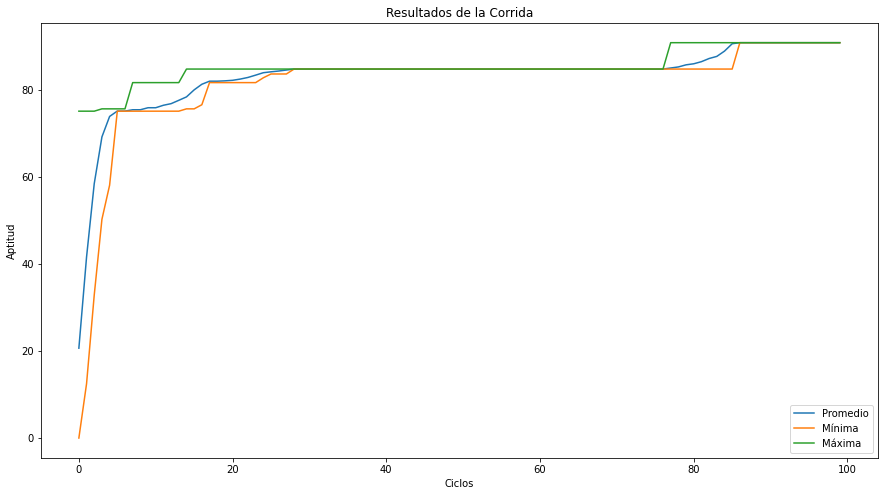

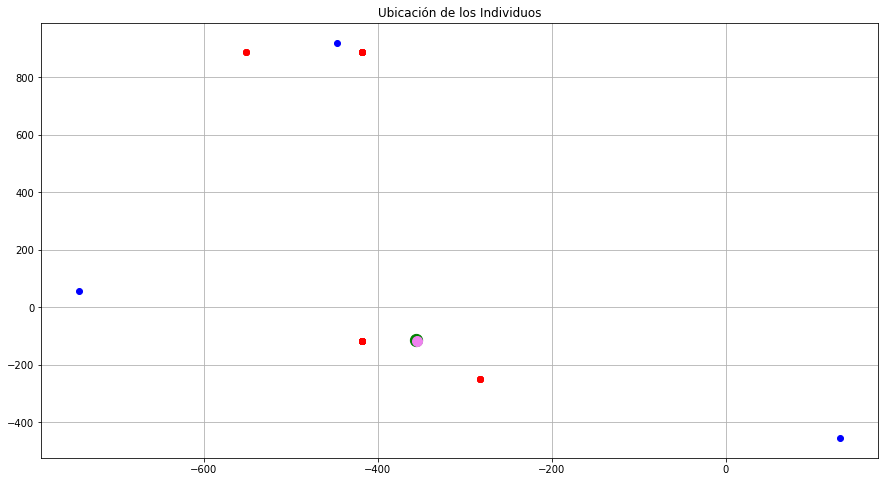

In [11]:
## MOSTRAR GRAFICO DE LA CORRIDA
plt.figure(figsize=(15,8)) 
plt.plot(ciclosPromAptitud)
plt.plot(ciclosMinAptitud)
plt.plot(ciclosMaxAptitud)
plt.title('Resultados de la Corrida')
plt.xlabel('Ciclos')
plt.ylabel('Aptitud')
plt.legend(['Promedio', 'Mínima', 'Máxima'], loc='lower right')
plt.show()


## MOSTRAR GRAFICO DE LA UBICACION DE LOS PUNTOS 
plt.figure(figsize=(15,8)) 

## --en Rojo: posiciones del mejor individuo de cada ciclo
for ind in ciclosMaxIndiv:
  plt.scatter(ind[0], ind[1], color='red')

## -- en Azul: Máximos Locales (positivos)
## -- en Cyan: Mínimos Locales (negativos)
## -- en Verde: Máximo Óptimo
for posi, vali in zip(mapa.posMaximos, mapa.valMaximos):    
  if vali < 0:
      plt.scatter(posi[0], posi[1], color='cyan')
  else:
      plt.scatter(posi[0], posi[1], color='blue')
plt.scatter(mapa.posMaximoGlobal[0], mapa.posMaximoGlobal[1], color='green', s=150)   

## --en Violeta: Individuo mejor ubicado
plt.scatter(ciclosMaxIndiv[mejorCiclo][0], ciclosMaxIndiv[mejorCiclo][1], color='violet', s=100)

plt.title('Ubicación de los Individuos')
#plt.xlim(MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ)
#plt.ylim(MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ)
plt.grid(True)
plt.show()
